## Priors and Semi-supervised Learning

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

Most classical machine learning algorithms either assume that an entire dataset is either labeled (supervised learning) or that there are no labels (unsupervised learning). However, frequently it is the case that some labeled data is present but there is a great deal of unlabeled data as well. A great example of this is that of computer vision where the internet is filled of pictures (mostly of cats) that could be useful, but you don't have the time or money to label them all in accordance with your specific task. Typically what ends up happening is that either the unlabeled data is discarded in favor of training a model solely on the labeled data, or that an unsupervised model is initialized with the labeled data and then set free on the unlabeled data. Neither method uses both sets of data in the optimization process.

Semi-supervised learning is a method to incorporate both labeled and unlabeled data into the training task, typically yield better performing estimators than using the labeled data alone. There are many methods one could use for semisupervised learning, and scikit-learn has a good write-up on some of these techniques.

pomegranate natively implements semi-supervised learning by accepting a matrix of prior probabilities for most classes. Specifically, the prior probabilities give the probability that an example maps to each component in the model, e.g. one of the distributions in a mixture model. When this probability is 1.0, it effectively acts as a hard label, saying that some example must come from that distribution. If all examples have prior probabilities of 1.0 for some component, this is exactly supervised learning. If some examples have prior probabilities of 1.0 and others are uniform, this corresponds to semi-supervised learning. When you have soft evidence, these prior probabilities can be between the uniform distribution and 1.0 to indicate some amount of confidence.

Note that prior probabilities are not the same as soft targets, in that the training is not aiming to classify each point as being proportionately from each distribution. For example, if the prior probabilities for an example given a model is `[0.4, 0.6]`, the learning objective does not attempt to make the underlying distributions yield `[0.4, 0.6]` for this example, but rather that the likelihood probabilities across distributions are multiplied by these values via Bayes' rule.

Let's take a look!

In [1]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')

import torch

numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,torch,pomegranate

Populating the interactive namespace from numpy and matplotlib
numpy        : 1.21.5
scipy        : 1.9.1
torch        : 1.13.1
torchegranate: 0.5.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.15.0-142-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



### Simple Setting

Let's first generate some data in the form of blobs that are close together. Generally one tends to have far more unlabeled data than labeled data, so let's say that a person only has 50 samples of labeled training data and 4950 unlabeled samples. In pomegranate you a sample can be specified as lacking a label by providing the integer -1 as the label, just like in scikit-learn. Let's also say there there is a bit of bias in the labeled samples to inject some noise into the problem, as otherwise Gaussian blobs are trivially modeled with even a few samples.

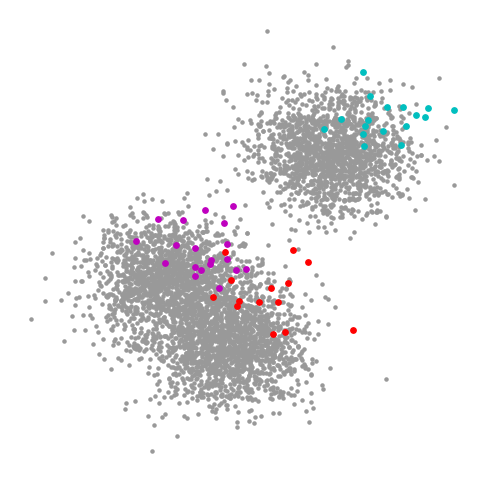

In [2]:
from sklearn.datasets import make_blobs
numpy.random.seed(1)

X, y = make_blobs(10000, n_features=2, centers=3, cluster_std=2)
X_train = X[:5000].astype('float32')
y_train = y[:5000]

# Set the majority of samples to unlabeled.
y_train[numpy.random.choice(5000, size=4950, replace=False)] = -1

# Inject noise into the problem
X_train[y_train != -1] += 2.5

X_test = X[5000:].astype('float32')
y_test = y[5000:]


plt.figure(figsize=(6, 6))
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], color='0.6', s=5)
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='c', s=15)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='m', s=15)
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1], color='r', s=15)
plt.axis('off')
plt.show()

The clusters of unlabeled data seem clear to us, and it doesn't seem like the labeled data is perfectly faithful to these clusters. This form of distributional shift can typically happen in a semisupervised setting as well, as the data that is labeled is sometimes biased either because the labeled data was chosen as it was easy to label, or the data was chosen to be labeled in a biased maner. However, because we have lots of unlabeled data, we can usually overcome such shifts.

Now let's try fitting a simple Bayes classifier to the labeled data and compare the accuracy and decision boundaries to when we fit a Gaussian mixture model in a semi-supervised way. As mentioned before, we can do semi-supervised learning by passing in a matrix of prior probabilities that are uniform when the label is unknown, and when the label is known has a value of 1.0 for the class corresponding to the label. 

In [3]:
from pomegranate.gmm import GeneralMixtureModel
from pomegranate.bayes_classifier import BayesClassifier
from pomegranate.distributions import Normal

idx = y_train != -1

model_a = BayesClassifier([Normal(), Normal(), Normal()])
model_a.fit(X_train[idx], y_train[idx])

y_hat_a = model_a.predict(X_test).numpy()
print("Supervised Learning Accuracy: {}".format((y_hat_a == y_test).mean()))

priors = torch.zeros(len(X_train), 3)
for i, y in enumerate(y_train):
    if y != -1:
        priors[i, y] = 1.0
    else:
        priors[i] = 1./3

dists = []
for i in range(3):
    dists.append(Normal().fit(X_train[y_train == i]))
        
model_b = GeneralMixtureModel(dists)
model_b.fit(X_train, priors=priors)

y_hat_b = model_b.predict(X_test).numpy()
print("Semisupervised Learning Accuracy: {}".format((y_hat_b == y_test).mean()))

Supervised Learning Accuracy: 0.8842
Semisupervised Learning Accuracy: 0.9228


It seems like we get a big bump in test set accuracy when we use semi-supervised learning. Note that, due to the smooth nature of prior probabilities, distributions are not initialized according to the hard labels at first. You can manually do this as above, though, where you first fit the distributions to the labeled data and then fine-tune on the entire data set given the prior probabilities. Let's visualize the data to get a better sense of what is happening here.

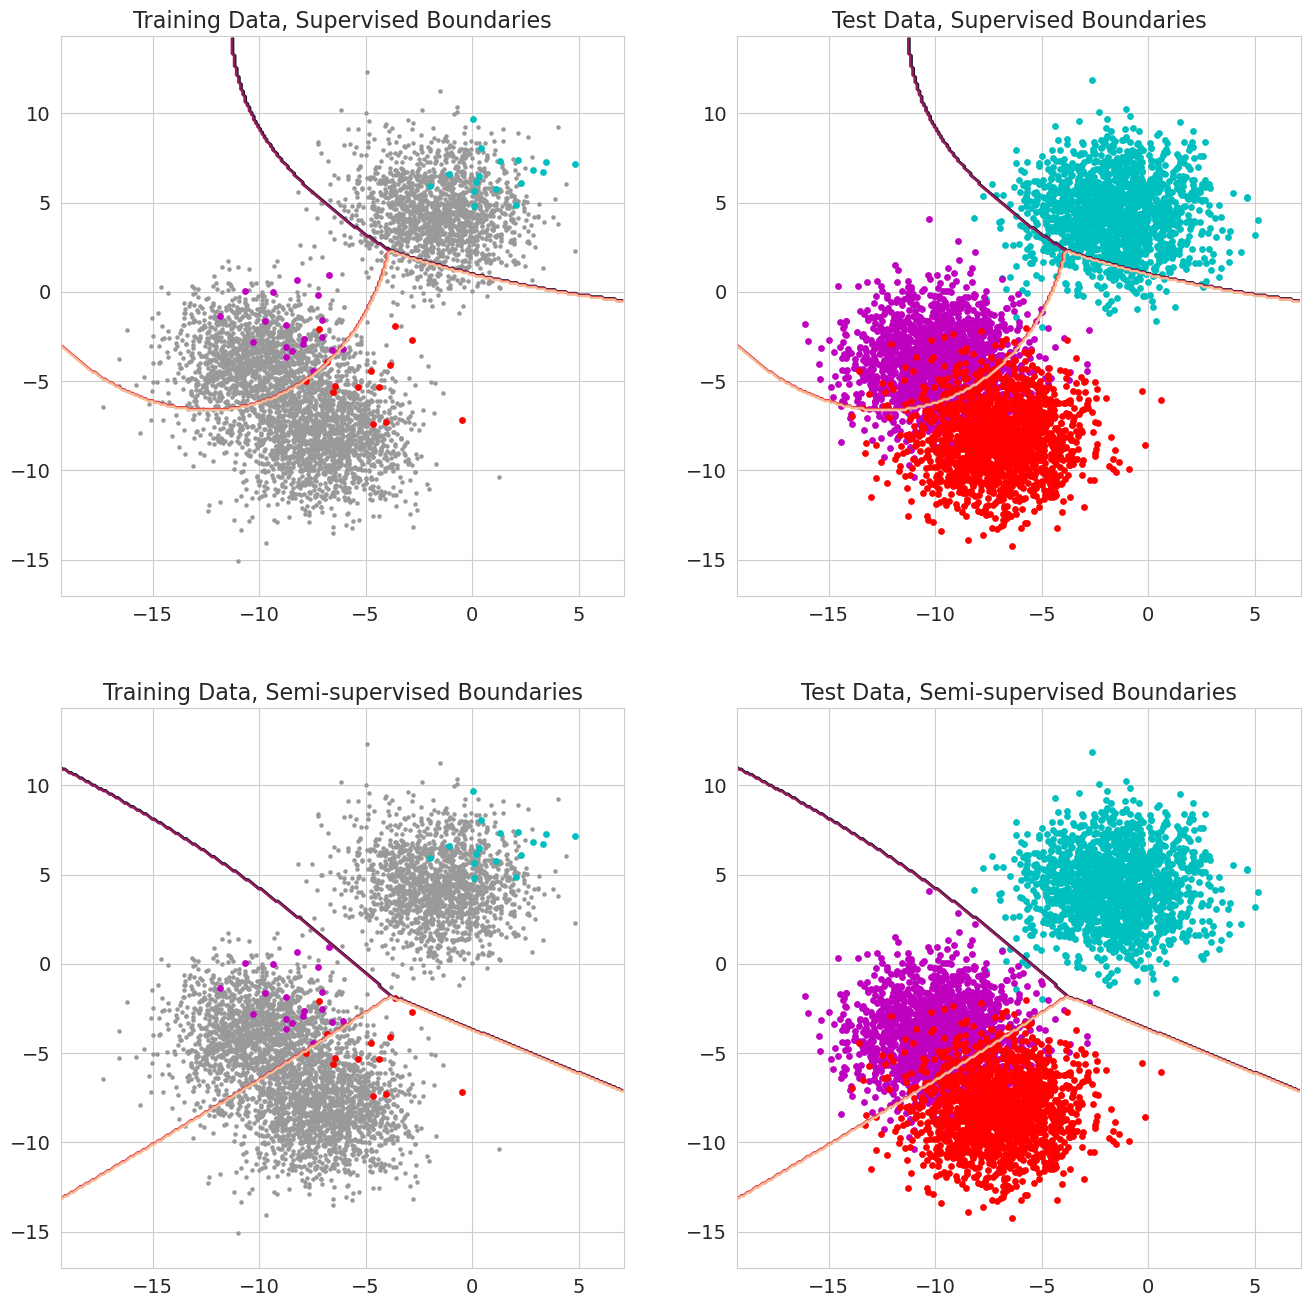

In [4]:
def plot_contour(X, y, Z):
    plt.scatter(X[y == -1, 0], X[y == -1, 1], color='0.6', s=5)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='c', s=15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='m', s=15)
    plt.scatter(X[y == 2, 0], X[y == 2, 1], color='r', s=15)
    plt.contour(xx, yy, Z)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

x_min, x_max = X[:,0].min()-2, X[:,0].max()+2
y_min, y_max = X[:,1].min()-2, X[:,1].max()+2
xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, 0.1), numpy.arange(y_min, y_max, 0.1))
Z1 = model_a.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z2 = model_b.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.title("Training Data, Supervised Boundaries", fontsize=16)
plot_contour(X_train, y_train, Z1)

plt.subplot(223)
plt.title("Training Data, Semi-supervised Boundaries", fontsize=16)
plot_contour(X_train, y_train, Z2)

plt.subplot(222)
plt.title("Test Data, Supervised Boundaries", fontsize=16)
plot_contour(X_test, y_test, Z1)

plt.subplot(224)
plt.title("Test Data, Semi-supervised Boundaries", fontsize=16)
plot_contour(X_test, y_test, Z2)
plt.show()

The contours plot the decision boundaries between the different classes with the left figures corresponding to the partially labeled training set and the right figures corresponding to the test set. We can see that the boundaries learning using only the labeled data look a bit weird when considering the unlabeled data, particularly in that it doesn't cleanly separate the cyan cluster from the other two. In addition, it seems like the boundary between the magenta and red clusters is a bit curved in an unrealistic way. We would not expect points that fell around (-18, -7) to actually come from the red class. Training the model in a semi-supervised manner cleaned up both of these concerns by learning better boundaries that are also flatter and more generalizable.

Let's next compare the training times to see how much slower it is to do semi-supervised learning than it is to do simple supervised learning.

In [5]:
from sklearn.semi_supervised import LabelPropagation

print("Supervised Learning")
%timeit BayesClassifier([Normal(), Normal(), Normal()]).fit(X_train[idx], y_train[idx])
print()

print("Semi-supervised Learning")
%timeit GeneralMixtureModel([Normal(), Normal(), Normal()]).fit(X_train, priors=priors)
print()

print("Label Propagation (sklearn): ")
#%timeit -n 1 -r 1 LabelPropagation().fit(X_train, y_train) # Setting to 1 loop because it takes a long time

Supervised Learning
The slowest run took 7.11 times longer than the fastest. This could mean that an intermediate result is being cached.
7.41 ms ± 7.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Semi-supervised Learning
73.2 ms ± 31.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Label Propagation (sklearn): 


It is quite a bit slower to do semi-supervised learning than simple supervised learning in this example. This is expected as the simple supervised update for Bayes classifier is a trivial MLE across each distribution whereas the semi-supervised case requires an iterative algorithm, EM, to converge. However, doing semi-supervised learning with EM is still much faster than fitting the label propagation estimator from sklearn.

### More Complicated Setting

Although the previous setting demonstrated our point, it was still fairly simple. We can construct a more complex situation where there are complex Gaussian distributions and each component is a mixture of distributions rather than a single one. This will highlight both the power of semi-supervised learning, as well as pomegranate's ability to stack models -- in this case, stack a mixture within a mixture.

First let's generate some more complicated, noisier data.

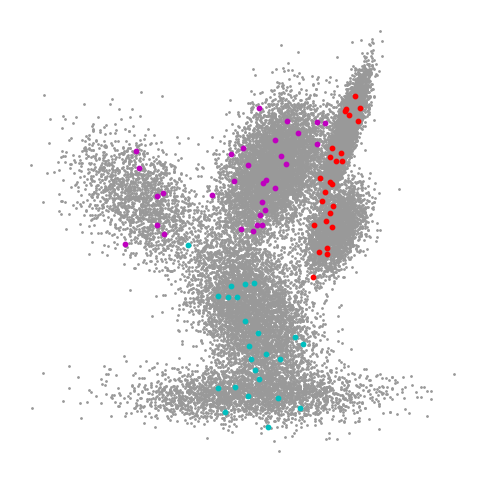

In [6]:
X = numpy.empty(shape=(0, 2))
X = numpy.concatenate((X, numpy.random.normal(4, 1, size=(3000, 2)).dot([[-2, 0.5], [2, 0.5]])))
X = numpy.concatenate((X, numpy.random.normal(3, 1, size=(6500, 2)).dot([[-1, 2], [1, 0.8]])))
X = numpy.concatenate((X, numpy.random.normal(7, 1, size=(8000, 2)).dot([[-0.75, 0.8], [0.9, 1.5]])))
X = numpy.concatenate((X, numpy.random.normal(6, 1, size=(2200, 2)).dot([[-1.5, 1.2], [0.6, 1.2]])))
X = numpy.concatenate((X, numpy.random.normal(8, 1, size=(3500, 2)).dot([[-0.2, 0.8], [0.7, 0.8]])))
X = numpy.concatenate((X, numpy.random.normal(9, 1, size=(6500, 2)).dot([[-0.0, 0.8], [0.5, 1.2]])))
X = X.astype('float32')

x_min, x_max = X[:,0].min()-2, X[:,0].max()+2
y_min, y_max = X[:,1].min()-2, X[:,1].max()+2

y = numpy.concatenate((numpy.zeros(9500), numpy.ones(10200), numpy.ones(10000)*2)).astype('int32')
idxs = numpy.arange(29700)
numpy.random.shuffle(idxs)

X = X[idxs]
y = y[idxs]

X_train, X_test = X[:25000], X[25000:]
y_train, y_test = y[:25000], y[25000:]
y_train[numpy.random.choice(25000, size=24920, replace=False)] = -1

plt.figure(figsize=(6, 6))
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], color='0.6', s=1)
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='c', s=10)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='m', s=10)
plt.scatter(X_train[y_train == 2, 0], X_train[y_train == 2, 1], color='r', s=10)
plt.axis('off')
plt.show()

Now let's take a look at the accuracies that we get when training a model using just the labeled examples versus all of the examples in a semi-supervised manner.

In [7]:
d1 = GeneralMixtureModel([Normal(), Normal()])
d2 = GeneralMixtureModel([Normal(), Normal()])
d3 = GeneralMixtureModel([Normal(), Normal()])

model_a = BayesClassifier([d1, d2, d3])
model_a.fit(X_train[y_train != -1], y_train[y_train != -1])

y_hat_a = model_a.predict(X_test).numpy() 
print("Supervised Learning Accuracy: {}".format((y_hat_a == y_test).mean()))

priors = torch.zeros(len(X_train), 3)
for i, y in enumerate(y_train):
    if y != -1:
        priors[i, y] = 1.0
    else:
        priors[i] = 1./3

d1 = GeneralMixtureModel([Normal(), Normal()]).fit(X_train[y_train == 0])
d2 = GeneralMixtureModel([Normal(), Normal()]).fit(X_train[y_train == 1])
d3 = GeneralMixtureModel([Normal(), Normal()]).fit(X_train[y_train == 2])

model_b = GeneralMixtureModel([d1, d2, d3])
model_b.fit(X_train, priors=priors)

y_hat_b = model_b.predict(X_test).numpy() 
print("Semisupervised Learning Accuracy: {}".format((y_hat_b == y_test).mean()))

Supervised Learning Accuracy: 0.9323404255319149
Semisupervised Learning Accuracy: 0.9846808510638297


As expected, the semi-supervised method performs better. Let's visualize the landscape in the same manner as before in order to see why this is the case.

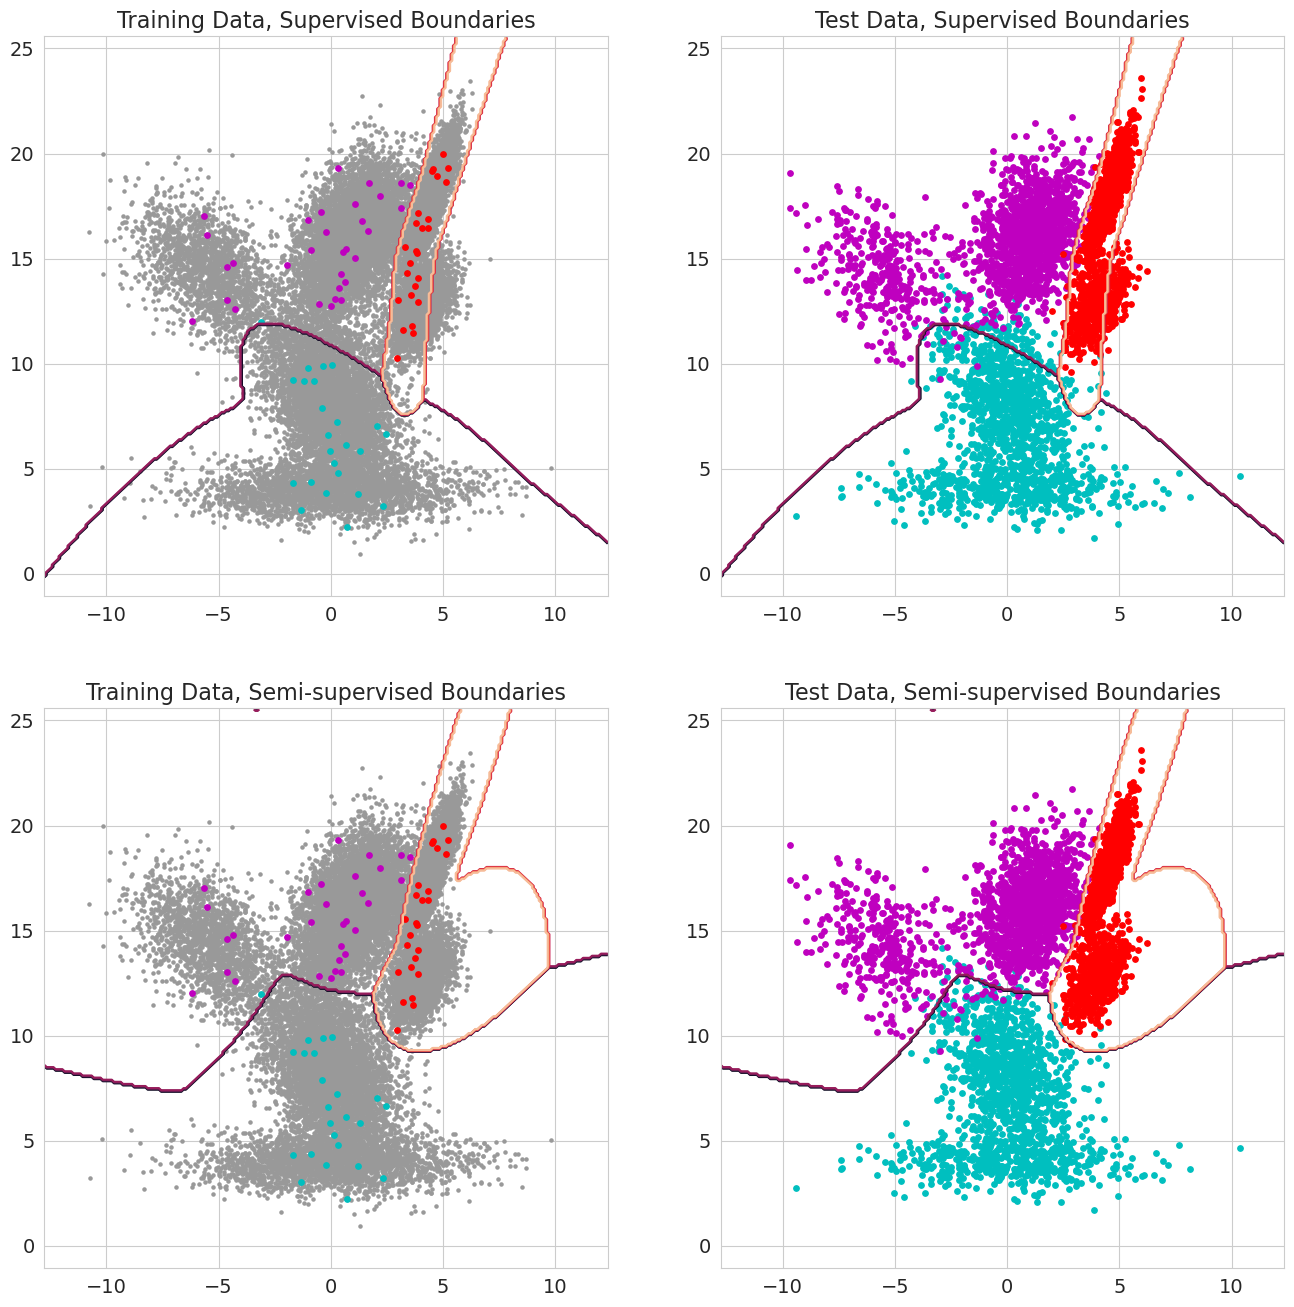

In [8]:
xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, 0.1), numpy.arange(y_min, y_max, 0.1))
Z1 = model_a.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
Z2 = model_b.predict(numpy.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.title("Training Data, Supervised Boundaries", fontsize=16)
plot_contour(X_train, y_train, Z1)

plt.subplot(223)
plt.title("Training Data, Semi-supervised Boundaries", fontsize=16)
plot_contour(X_train, y_train, Z2)

plt.subplot(222)
plt.title("Test Data, Supervised Boundaries", fontsize=16)
plot_contour(X_test, y_test, Z1)

plt.subplot(224)
plt.title("Test Data, Semi-supervised Boundaries", fontsize=16)
plot_contour(X_test, y_test, Z2)
plt.show()

Immediately, one would notice that the decision boundaries when using semi-supervised learning are smoother than those when using only a few samples. This can be explained mostly because having more data can generally lead to smoother decision boundaries as the model does not overfit to spurious examples in the dataset. It appears that the majority of the correctly classified samples come from having a more accurate decision boundary for the magenta samples in the left cluster. When using only the labeled samples many of the magenta samples in this region get classified incorrectly as cyan samples. In contrast, when using all of the data these points are all classified correctly.

### HMMs

Hidden Markov models can take in priors just as easily as mixture models can. Just as the data must be 3D, the priors also must be 3D.

In [9]:
from pomegranate.hmm import DenseHMM

d1 = Normal([1.0], [1.0], covariance_type='diag')
d2 = Normal([3.0], [1.0], covariance_type='diag')

model = DenseHMM([d1, d2], [[0.7, 0.3], [0.3, 0.7]], starts=[0.4, 0.6])

We can first look at what a forward pass would look like without priors.

In [10]:
X = torch.randn(1, 10, 1)

model.predict_proba(X)

tensor([[[9.9965e-01, 3.4963e-04],
         [9.9931e-01, 6.9394e-04],
         [9.9523e-01, 4.7742e-03],
         [9.4235e-01, 5.7645e-02],
         [9.9667e-01, 3.3334e-03],
         [9.9878e-01, 1.2166e-03],
         [9.9401e-01, 5.9913e-03],
         [9.9711e-01, 2.8869e-03],
         [9.9876e-01, 1.2349e-03],
         [9.4717e-01, 5.2828e-02]]])

Now let's add in that one observation must map to one specific state.

In [11]:
priors = torch.ones(1, 10, 2) / 2
priors[0, 5, 0], priors[0, 5, 1] = 0, 1
priors

tensor([[[0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.0000, 1.0000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000],
         [0.5000, 0.5000]]])

In [12]:
model.predict_proba(X, priors=priors)

tensor([[[9.9965e-01, 3.4963e-04],
         [9.9931e-01, 6.9407e-04],
         [9.9518e-01, 4.8200e-03],
         [9.3960e-01, 6.0401e-02],
         [9.8221e-01, 1.7790e-02],
         [0.0000e+00, 1.0000e+00],
         [9.6839e-01, 3.1612e-02],
         [9.9680e-01, 3.2024e-03],
         [9.9876e-01, 1.2366e-03],
         [9.4717e-01, 5.2828e-02]]])

We can see that the model is forced to assign the 6th observation to distribution 1 even though it is trying to assign all of the observations to distribution 0.

Using prior probabilities like this gives us a way to do semi-supervised learning on HMMs in a very flexible manner. If you have entire labeled sequences, you can pass in prior probabilities of 1.0 for each observation in the sequence, even if other sequences have no labels at all. If you have partially labeled sequences, you can easily train your model using priors on some, but not all, observations, and using those partial observations to inform everything else.

## Summary

In the real world (ack) there are frequently situations where only a small fraction of the available data has useful labels. Semi-supervised learning provides a framework for leveraging both the labeled and unlabeled aspects of a dataset to learn a sophisticated estimator. In this case, semi-supervised learning plays well with probabilistic models as normal maximum likelihood estimates can be done on the labeled data and expectation-maximization can be run on the unlabeled data using the same distributions.

This notebook has covered how to implement semi-supervised learning in pomegranate using mixture models and hidden Markov models. All one has to do is set the priors of observations consistently with the labels and pomegranate will take care of the rest. This can be particularly useful when encountering complex, noisy, data in the real world that aren't neat Gaussian blobs.